In [1]:
import scanpy as sc
from tqdm import tqdm
from sklearn.metrics import r2_score
import numpy as np
import pandas as pd
from ott.tools.sinkhorn_divergence import sinkhorn_divergence
from ott.geometry import costs, pointcloud
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import anndata as ad

In [2]:
def compute_r_squared(x: np.ndarray, y: np.ndarray) -> float:
    return r2_score(np.mean(x, axis=0), np.mean(y, axis=0))

def calc_pert_effect(adata, controls, pathway, run_sinkhorn=False, use_pca=True):
    pert_effects = {
        'pathway': pathway,
        'cell_type': [],
        'gene': [],
        'r2': [],
        'sinkhorn': []
    }
    for c in tqdm(adata.obs["condition"].unique()):
        if not c.endswith('_NT'):
            if use_pca:
                y = adata[adata.obs["condition"]==c].obsm["X_pca"]
            else:
                y = adata[adata.obs["condition"]==c].X.A
            cell_type, gene = c.split("_")
            pert_effects['gene'].append(gene)
            pert_effects['cell_type'].append(cell_type)
            pert_effects['r2'].append(r2_score(
                np.mean(controls[cell_type], axis=0),
                np.mean(y, axis=0)
            ))
            if run_sinkhorn:
                pert_effects['sinkhorn'].append(float(sinkhorn_divergence(
                    pointcloud.PointCloud,
                    x=controls[cell_type],
                    y=y,
                    cost_fn=costs.SqEuclidean(),
                    epsilon=1e-1,
                    scale_cost=1.0,
                ).divergence))
            else:
                pert_effects['sinkhorn'] = None
    return pd.DataFrame(pert_effects)

In [4]:
datasets = []
file_paths = glob.glob('data/satija_h5ad/*.h5ad')
for file_path in file_paths:
    pathway = file_path.split('/')[-1].split('_')[0]
    adata = sc.read(file_path)
    adata.obs['pathway'] = pathway
    adata.obs['condition'] = adata.obs.apply(lambda x: "_".join([x.cell_type, x.gene]), axis=1)
    sc.pp.highly_variable_genes(adata, inplace=True, n_top_genes=2000)
    adata = adata[:,adata.var["highly_variable"]==True]
    sc.pp.pca(adata)
    datasets.append(adata)

/lustre/groups/ml01/workspace/lea.zimmermann/software/miniconda3/envs/ott/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:314: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm["X_pca"] = X_pca
/lustre/groups/ml01/workspace/lea.zimmermann/software/miniconda3/envs/ott/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:314: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm["X_pca"] = X_pca
/lustre/groups/ml01/workspace/lea.zimmermann/software/miniconda3/envs/ott/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:314: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm["X_pca"] = X_pca
/lustre/groups/ml01/workspace/lea.zimmermann/software/miniconda3/envs/ott/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:314: ImplicitModificationWarning: Setting element `.obsm['X_pca']` 

In [24]:
pert_effect_per_pathway = []
for adata in datasets:
    controls = {}
    control_adata = adata[adata.obs['gene'] == 'NT', :]
    for cell_type in control_adata.obs['cell_type'].unique():
        controls[cell_type] = control_adata[control_adata.obs['cell_type'] == cell_type].obsm['X_pca']
    pathway = adata.obs['pathway']
    pert_effect_per_pathway.append(calc_pert_effect(adata, controls, pathway=adata.obs['pathway'].iloc[0]))

pert_effects = pd.concat(pert_effect_per_pathway)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 360/360 [00:04<00:00, 73.46it/s]


In [25]:
pert_effects

,pathway,cell_type,gene,r2,sinkhorn
0,TGFB,A549,RUNX2,0.999244,None
1,TGFB,A549,RPS6KB1,0.999162,None
2,TGFB,A549,PPP2CA,0.998673,None
3,TGFB,A549,RUNX1,0.999724,None
4,TGFB,A549,EP300,0.999395,None
...,...,...,...,...,...
349,IFNG,K562,CUL1,0.993556,None
350,IFNG,K562,IFI16,0.997355,None
351,IFNG,HAP1,SOX2,0.987351,None
352,IFNG,HAP1,KIN,0.997149,None


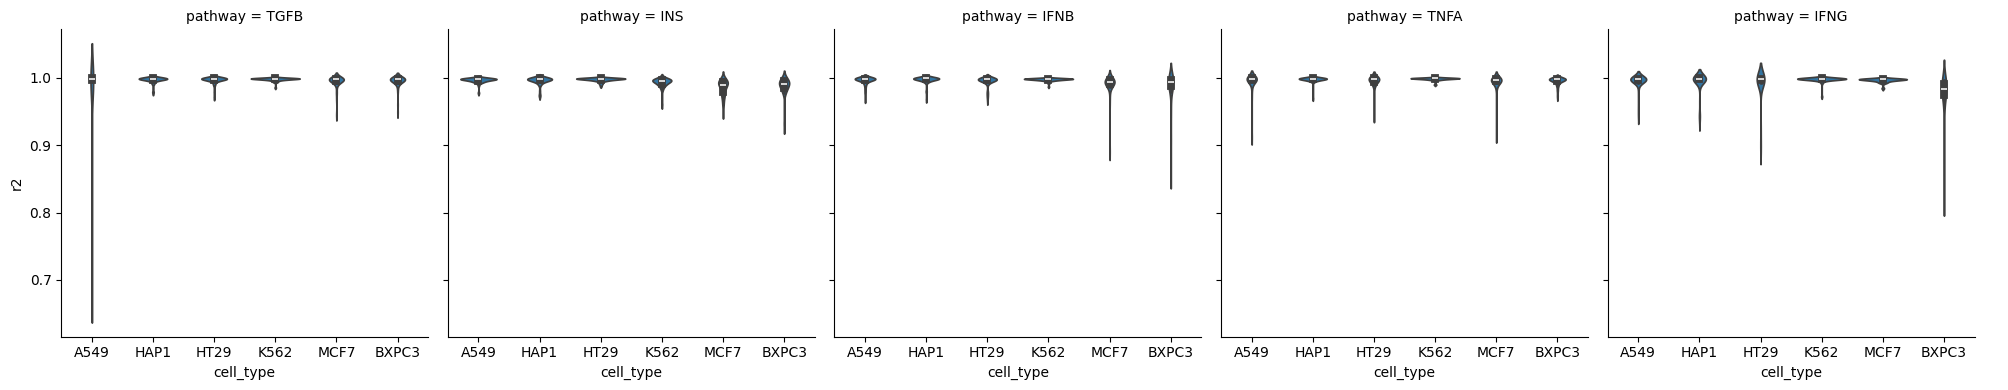

In [26]:
g = sns.FacetGrid(pert_effects, col='pathway', height=4, aspect=1)
g.map_dataframe(sns.violinplot, x='cell_type', y='r2')
g.add_legend()
plt.show()

In [4]:
file_paths = glob.glob('data/satija_h5ad/*.h5ad')

In [4]:
ifng_path = 'data/satija_h5ad/IFNG_Perturb_seq.h5ad'
ifng_adata = sc.read(ifng_path)

In [5]:
hvc = 2000

cell_type_spec_datasets = []
for ct in ifng_adata.obs['cell_type'].unique():
    ds = ifng_adata[ifng_adata.obs['cell_type'] == ct, :].copy()
    sc.pp.highly_variable_genes(ds, inplace=True, n_top_genes=hvc)
    ds = ds[:,ds.var["highly_variable"]==True]
    sc.pp.pca(ds)
    cell_type_spec_datasets.append(ds)

/lustre/groups/ml01/workspace/lea.zimmermann/software/miniconda3/envs/ott/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:314: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm["X_pca"] = X_pca
/lustre/groups/ml01/workspace/lea.zimmermann/software/miniconda3/envs/ott/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:314: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm["X_pca"] = X_pca
/lustre/groups/ml01/workspace/lea.zimmermann/software/miniconda3/envs/ott/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:314: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm["X_pca"] = X_pca
/lustre/groups/ml01/workspace/lea.zimmermann/software/miniconda3/envs/ott/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:314: ImplicitModificationWarning: Setting element `.obsm['X_pca']` 

In [6]:
cell_type_spec_datasets_filtered = []
for adata in cell_type_spec_datasets:
    adata.obs['condition'] = adata.obs.apply(lambda x: "_".join([x.cell_type, x.gene]), axis=1)
    condition_counts = adata.obs['condition'].value_counts()
    conditions_with_at_least_100 = condition_counts[condition_counts >= 100].index.tolist()
    adata_filtered = adata[adata.obs['condition'].isin(conditions_with_at_least_100), :]
    cell_type_spec_datasets_filtered.append(adata_filtered)

In [7]:
pert_effect_per_cell_type = []
for adata in cell_type_spec_datasets_filtered:
    adata.obs['condition'] = adata.obs.apply(lambda x: "_".join([x.cell_type, x.gene]), axis=1)
    controls = {}
    control_adata = adata[adata.obs['gene'] == 'NT', :]
    for cell_type in control_adata.obs['cell_type'].unique():
        controls[cell_type] = control_adata[control_adata.obs['cell_type'] == cell_type].obsm['X_pca']
    pert_effect_per_cell_type.append(calc_pert_effect(adata, controls, pathway='ifng',run_sinkhorn=True))

pert_effect_per_cell_type = pd.concat(pert_effect_per_cell_type)

/tmp/ipykernel_1250748/3443187542.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['condition'] = adata.obs.apply(lambda x: "_".join([x.cell_type, x.gene]), axis=1)
100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [02:47<00:00,  2.94s/it]
/tmp/ipykernel_1250748/3443187542.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['condition'] = adata.obs.apply(lambda x: "_".join([x.cell_type, x.gene]), axis=1)
100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 53/53 [03:21<00:00,  3.81s/it]
/tmp/ipykernel_1250748/3443187542.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['condition'] = adata.obs.apply(lambda x: "_".join([x.cell_type, x.gene]), axis=1)
100%|██████████████████

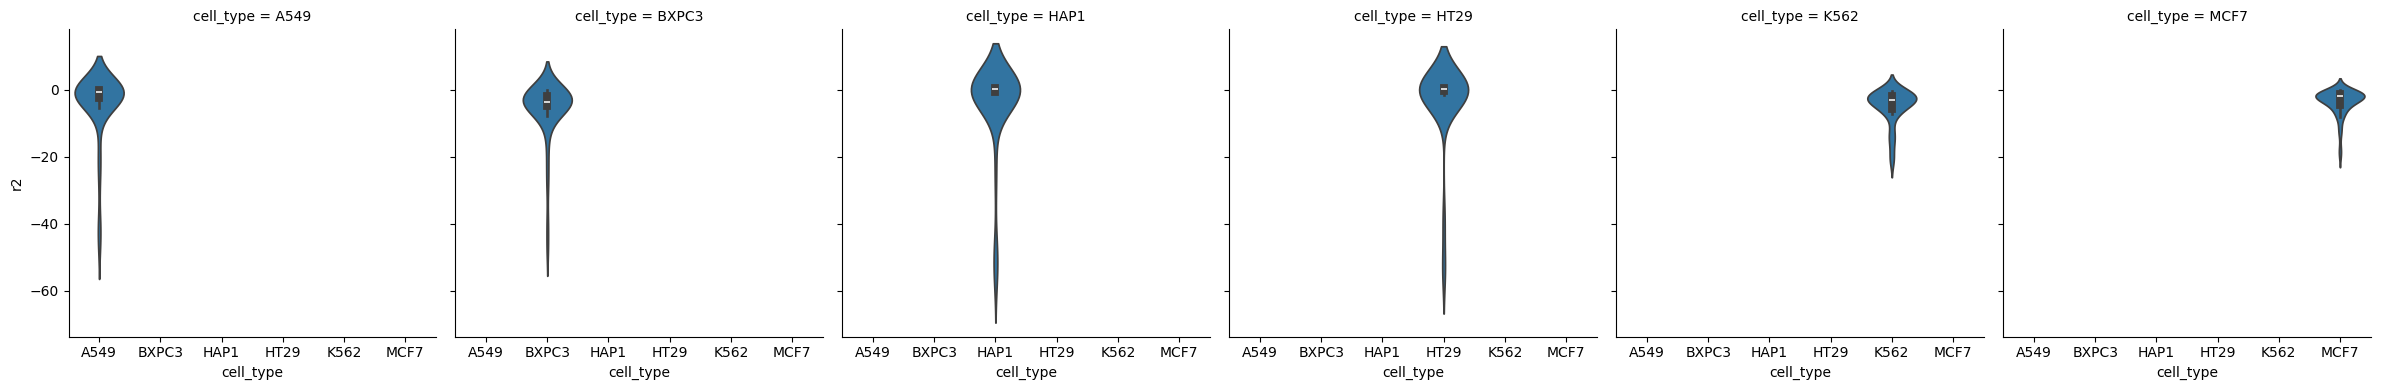

In [23]:
g = sns.FacetGrid(pert_effect_per_cell_type, col='cell_type', height=4, aspect=1)
g.map_dataframe(sns.violinplot, x='cell_type', y='r2')
g.add_legend()
plt.show()

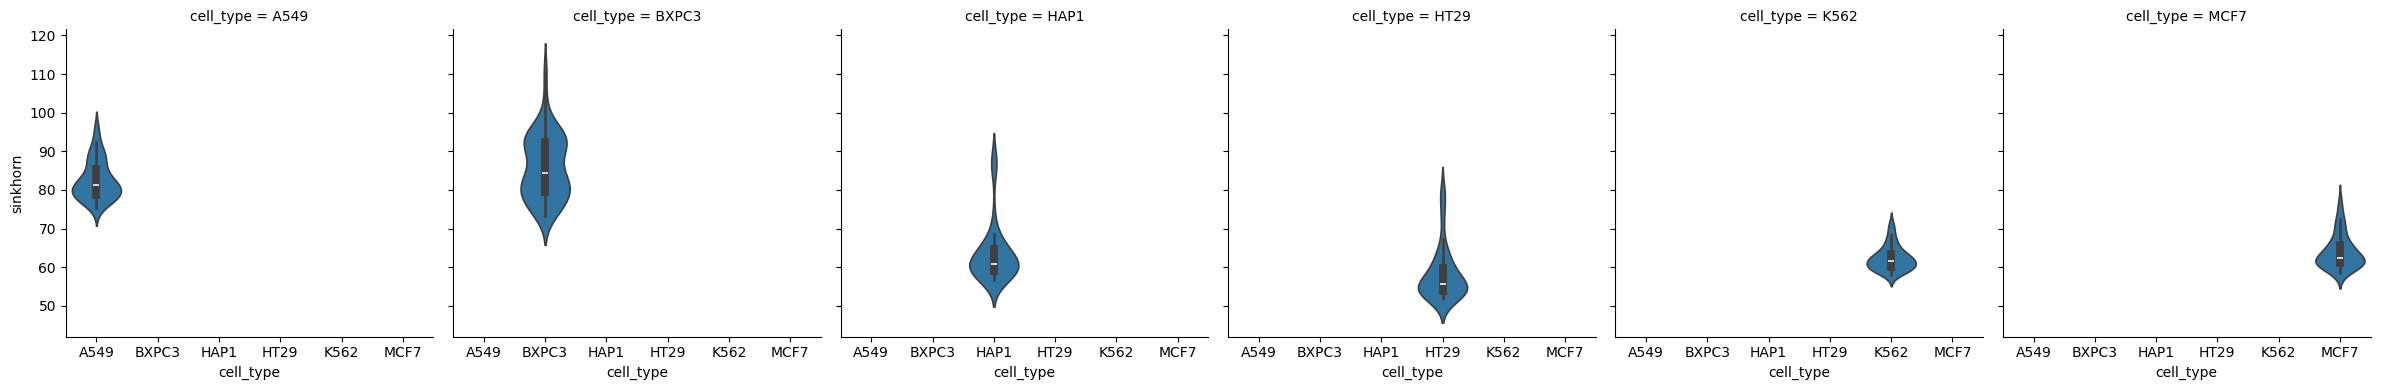

In [8]:
g = sns.FacetGrid(pert_effect_per_cell_type, col='cell_type', height=4, aspect=1)
g.map_dataframe(sns.violinplot, x='cell_type', y='sinkhorn')
g.add_legend()
plt.show()

In [19]:
cell_type_spec_datasets[4].obs['cell_type']

01_24_31_1_1_1_1_1_1_1_1_1    K562
01_92_20_1_1_1_1_1_1_1_1_1    K562
01_33_10_1_1_1_1_1_1_1_1_1    K562
02_61_42_1_1_1_1_1_1_1_1_1    K562
02_31_09_1_1_1_1_1_1_1_1_1    K562
                              ... 
03_36_72_2_2                  K562
03_56_55_2_2                  K562
01_25_11_2_2                  K562
04_77_80_2_2                  K562
04_12_07_2_2                  K562
Name: cell_type, Length: 28005, dtype: category
Categories (1, object): ['K562']

In [22]:
pert_effect_per_cell_type[pert_effect_per_cell_type['cell_type']=='K562'].sort_values(by='r2',ascending=True)

,pathway,cell_type,gene,r2,sinkhorn
58,ifng,K562,SOX2,-62.713866,None
22,ifng,K562,IFNGR1,-21.399812,None
9,ifng,K562,STAT1,-20.995867,None
56,ifng,K562,CUL1,-19.612195,None
42,ifng,K562,EHF,-19.162261,None
2,ifng,K562,IFNGR2,-15.746024,None
8,ifng,K562,JAK2,-15.662341,None
55,ifng,K562,ZC3H3,-13.949912,None
3,ifng,K562,STAT3,-12.506206,None
12,ifng,K562,JAK1,-12.293662,None


In [25]:
strong_effects = pert_effect_per_cell_type[pert_effect_per_cell_type['cell_type']=='K562'].query('r2 <= -10.0')['gene']

In [33]:
strong_effects = pd.concat([strong_effects, pd.Series('NT')])

In [34]:
strong_effects

2     IFNGR2
3      STAT3
8       JAK2
9      STAT1
12      JAK1
22    IFNGR1
42       EHF
55     ZC3H3
56      CUL1
58      SOX2
0         NT
dtype: object

In [39]:
K562_strong = cell_type_spec_datasets[0][cell_type_spec_datasets[0].obs['gene'].isin(strong_effects),:]

In [45]:
K562_strong.obs['gene'].value_counts()

gene
IFNGR2    1165
NT        1018
JAK2      1000
JAK1       715
IFNGR1     604
STAT1      590
STAT3      475
ZC3H3      367
CUL1       331
EHF        321
SOX2        45
Name: count, dtype: int64

In [47]:
sc.pp.neighbors(K562_strong)
sc.tl.umap(K562_strong)

/lustre/groups/ml01/workspace/lea.zimmermann/software/miniconda3/envs/ott/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-04-26 10:41:07.865467: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


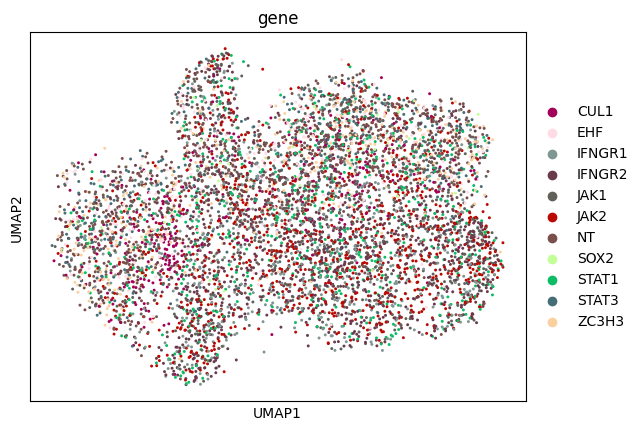

In [49]:
sc.pl.umap(K562_strong, color='gene')

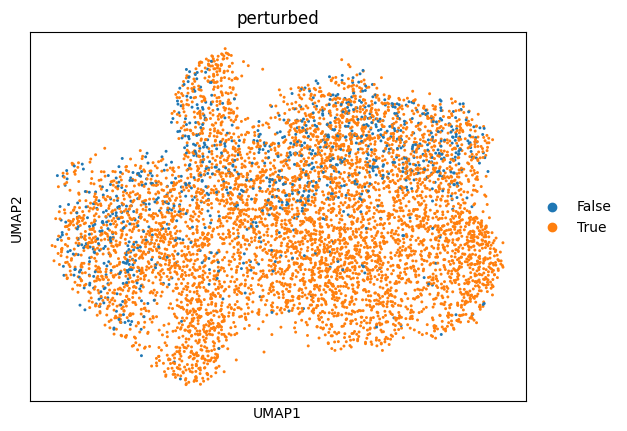

In [50]:
sc.pl.umap(K562_strong, color='perturbed')

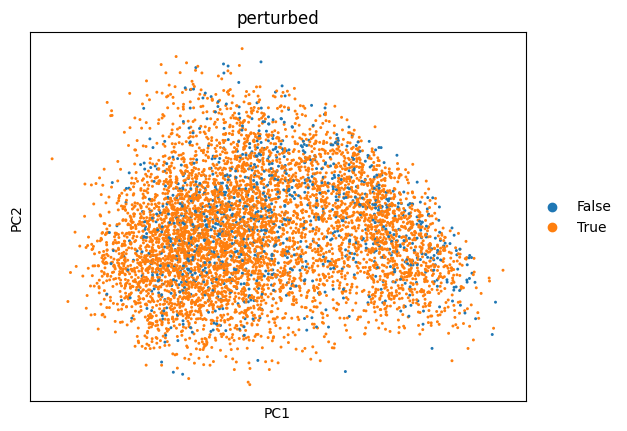

In [40]:
sc.pl.pca(K562_strong, color='perturbed')

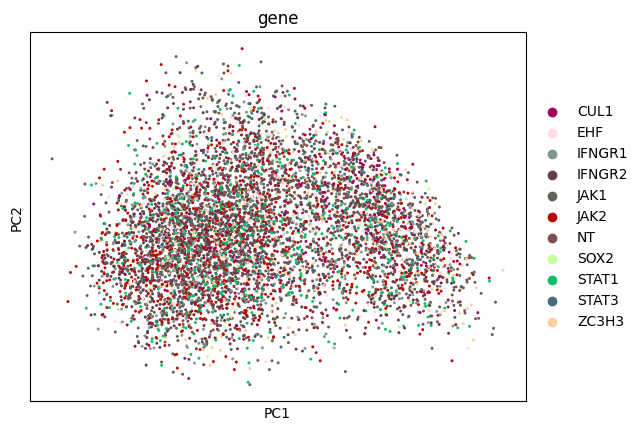

In [41]:
sc.pl.pca(K562_strong, color='gene')

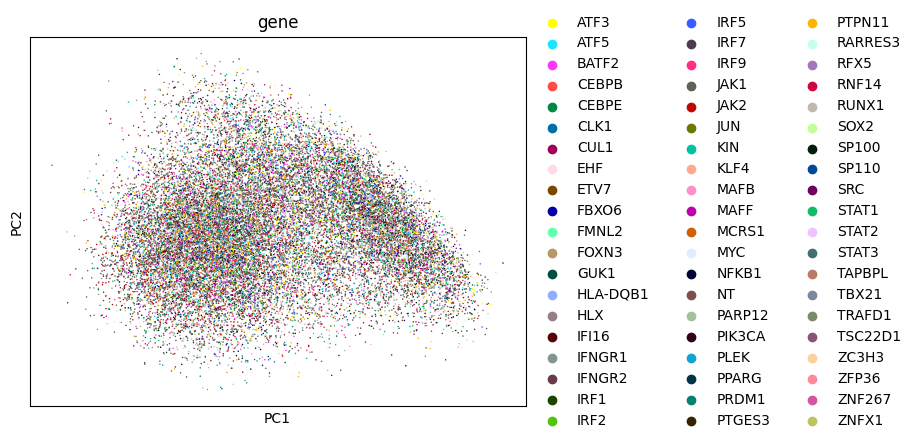

In [18]:
sc.pl.pca(cell_type_spec_datasets[0], color='gene')

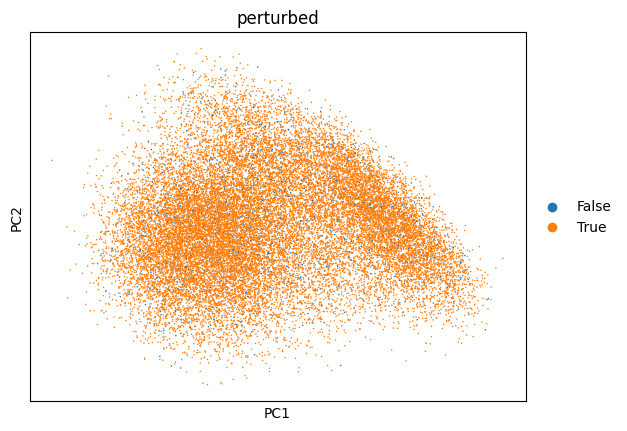

In [38]:
cell_type_spec_datasets[0].obs['perturbed'] = cell_type_spec_datasets[0].obs['gene'] != 'NT'
sc.pl.pca(cell_type_spec_datasets[0], color='perturbed')

In [57]:
control_adata[control_adata.obs['cell_type'] == cell_type].X.A

array([[0.        , 0.        , 0.81631488, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 1.57422904, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 2.2493704 , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [9]:
pert_effect_per_cell_type_fg = []
for adata in cell_type_spec_datasets_filtered:
    #adata.obs['condition'] = adata.obs.apply(lambda x: "_".join([x.cell_type, x.gene]), axis=1)
    controls = {}
    control_adata = adata[adata.obs['gene'] == 'NT', :]
    for cell_type in control_adata.obs['cell_type'].unique():
        controls[cell_type] = control_adata[control_adata.obs['cell_type'] == cell_type].X.A
    pert_effect_per_cell_type_fg.append(calc_pert_effect(adata, controls, pathway='ifng',use_pca=False, run_sinkhorn=True))

pert_effect_per_cell_type_fg = pd.concat(pert_effect_per_cell_type_fg)

100%|██████████████████████████████████████████████████| 60/60 [03:54<00:00,  3.91s/it]


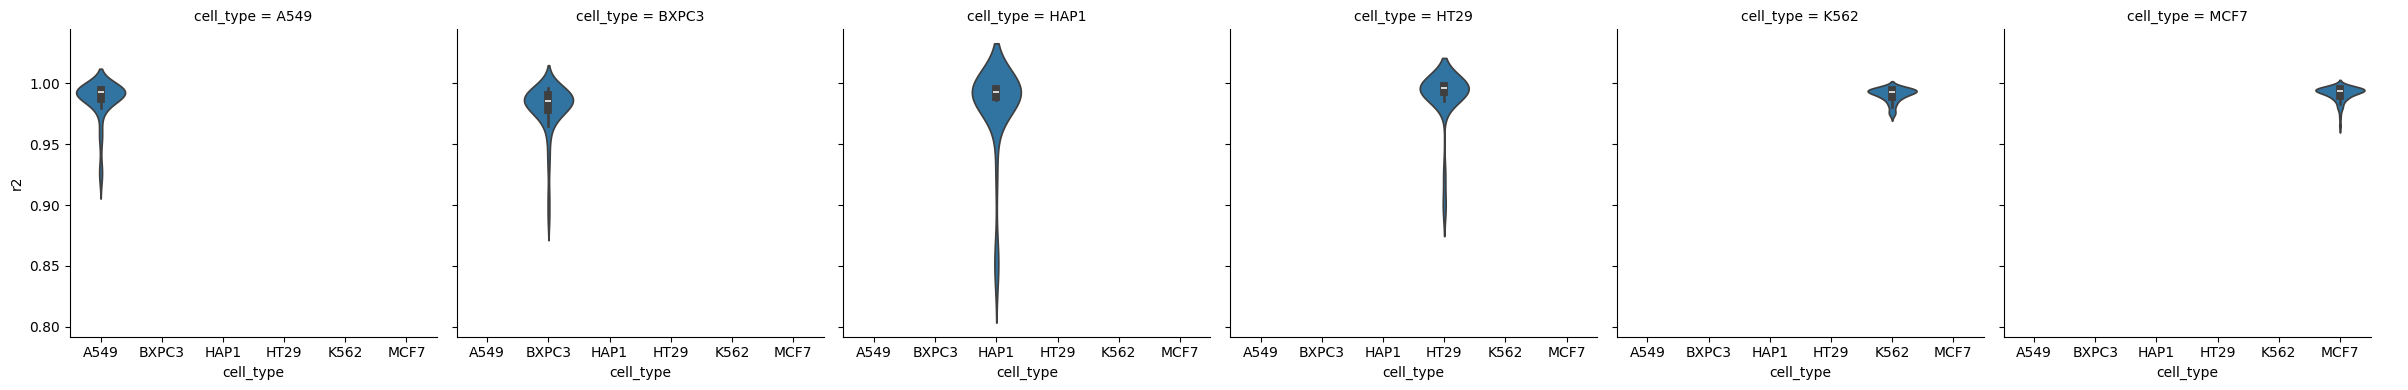

In [10]:
g = sns.FacetGrid(pert_effect_per_cell_type_fg, col='cell_type', height=4, aspect=1)
g.map_dataframe(sns.violinplot, x='cell_type', y='r2')
g.add_legend()
plt.show()

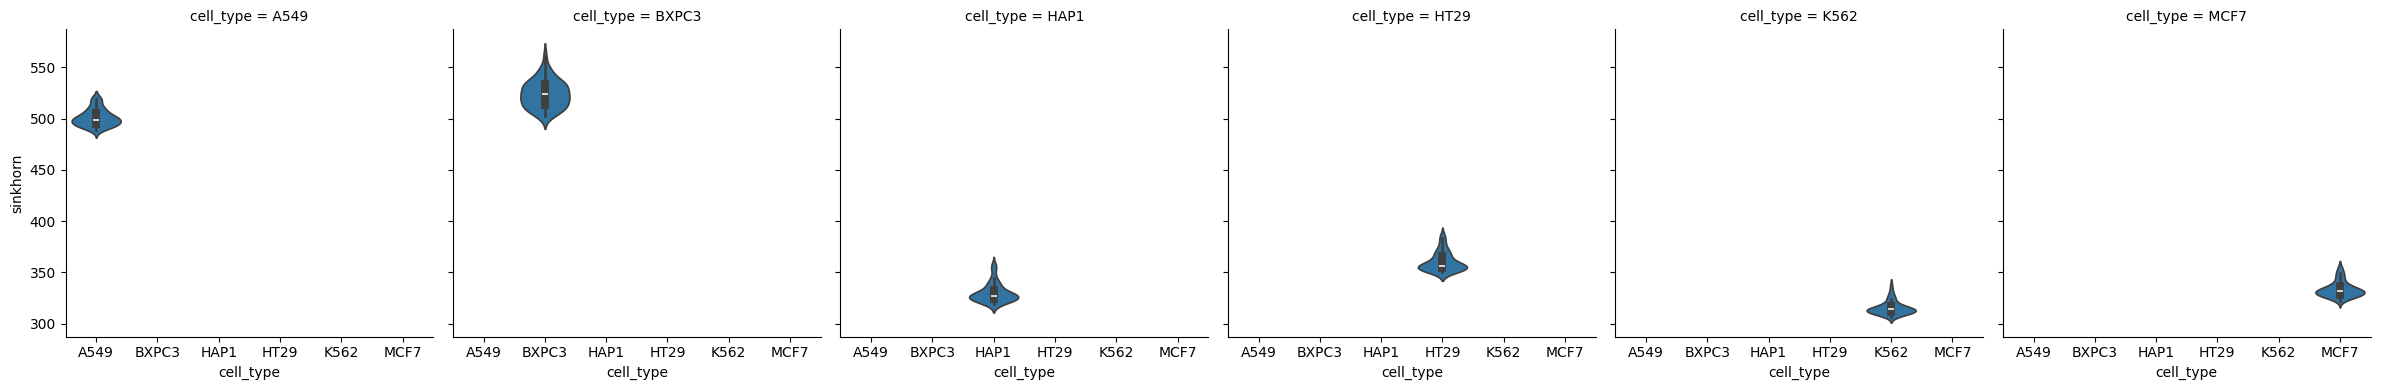

In [11]:
g = sns.FacetGrid(pert_effect_per_cell_type_fg, col='cell_type', height=4, aspect=1)
g.map_dataframe(sns.violinplot, x='cell_type', y='sinkhorn')
g.add_legend()
plt.show()

In [18]:
DE_expressed_genes_ifng = ['WARS', 'TAP2', 'TAP1', 'STAT1', 'RNF213', 'PARP14', 'NLRC5', 'LAP3', 'IRF1', 'GBP1']

In [15]:
bxpc3 = cell_type_spec_datasets_filtered[1]

In [31]:
bxpc3.var[bxpc3.var.index.to_series().apply(lambda x: x.split('.')[0] in DE_expressed_genes_ifng)]

,vst.mean,vst.variance,vst.variance.expected,vst.variance.standardized,vst.variable,highly_variable,means,dispersions,dispersions_norm
WARS,7.314814,108.883252,92.046007,1.182922,False,True,3.094024,2.528327,1.121715


In [33]:
bxpc3.var[bxpc3.var.index.to_series().apply(lambda x: x.startswith('TAP'))]

,vst.mean,vst.variance,vst.variance.expected,vst.variance.standardized,vst.variable,highly_variable,means,dispersions,dispersions_norm


In [ ]:
bxpc3[:,[i.split('.')[0] for i in bxpc3.var.index].isin(DE_expressed_genes_ifng)].var

In [ ]:
[i.split('.')[0].isin(DE_expressed_genes_ifng) for i in bxpc3.var.index]

In [13]:
cell_type_spec_datasets_filtered[0].var

,vst.mean,vst.variance,vst.variance.expected,vst.variance.standardized,vst.variable,highly_variable,means,dispersions,dispersions_norm
GCLC,0.609509,1.358230,1.264864,1.073815,False,True,0.734326,1.529091,3.233976
AOC1,0.003601,0.003979,0.003884,1.024361,False,True,0.000949,1.435940,1.071411
CD38,0.056744,0.168009,0.071154,2.361201,True,True,0.619428,1.508727,3.003478
MEOX1,0.001586,0.001853,0.001679,1.103216,False,True,0.000907,1.787603,2.087421
THSD7A,0.256679,0.942960,0.403938,2.334417,True,True,0.738074,1.652567,4.631622
...,...,...,...,...,...,...,...,...,...
AC011124.2,0.000045,0.000045,0.000046,0.977075,False,True,0.000189,1.583770,1.498515
MAP2K1P1,0.000049,0.000049,0.000050,0.976660,False,True,0.000178,1.524637,1.327671
AC009065.3,0.000065,0.000065,0.000067,0.975581,False,True,0.000168,1.464905,1.155095
TMEM202,0.000020,0.000020,0.000021,0.982334,False,True,0.000254,1.880591,2.356076


In [21]:
pert_effect_per_cell_type_fg.sort_values(by='r2',ascending=True)

,pathway,cell_type,gene,r2,sinkhorn
16,ifng,HAP1,IFNGR2,0.839084,None
35,ifng,HAP1,STAT1,0.847708,None
36,ifng,HAP1,JAK2,0.855655,None
46,ifng,HAP1,IFNGR1,0.864623,None
49,ifng,BXPC3,STAT1,0.889638,None
...,...,...,...,...,...
25,ifng,HT29,TBX21,0.998620,None
14,ifng,HT29,ETV7,0.998634,None
3,ifng,HT29,PRDM1,0.998680,None
2,ifng,HT29,PTPN11,0.998851,None


In [25]:
pert_effect_per_cell_type_fg.query('cell_type == "BXPC3"').sort_values(by='r2',ascending=True)

,pathway,cell_type,gene,r2,sinkhorn
49,ifng,BXPC3,STAT1,0.889638,None
14,ifng,BXPC3,IFNGR1,0.907200,None
27,ifng,BXPC3,JAK1,0.932096,None
10,ifng,BXPC3,IFNGR2,0.945194,None
30,ifng,BXPC3,JAK2,0.957439,None
24,ifng,BXPC3,MAFF,0.964863,None
26,ifng,BXPC3,IRF2,0.966842,None
5,ifng,BXPC3,ZC3H3,0.970208,None
41,ifng,BXPC3,IFI16,0.974317,None
44,ifng,BXPC3,ZFP36,0.976344,None


In [26]:
pert_effect_per_cell_type_fg.query('cell_type == "HAP1"').sort_values(by='r2',ascending=True)

,pathway,cell_type,gene,r2,sinkhorn
16,ifng,HAP1,IFNGR2,0.839084,None
35,ifng,HAP1,STAT1,0.847708,None
36,ifng,HAP1,JAK2,0.855655,None
46,ifng,HAP1,IFNGR1,0.864623,None
20,ifng,HAP1,JAK1,0.919681,None
37,ifng,HAP1,IRF1,0.943406,None
7,ifng,HAP1,HLX,0.969446,None
49,ifng,HAP1,ZC3H3,0.972634,None
39,ifng,HAP1,EHF,0.986253,None
25,ifng,HAP1,IRF9,0.986980,None


In [41]:
cell_type_spec_datasets_filtered[2].obs['condition'].value_counts()

condition
HAP1_NT          1061
HAP1_RUNX1        947
HAP1_BATF2        845
HAP1_STAT1        844
HAP1_IFNGR2       827
HAP1_ETV7         776
HAP1_IRF5         713
HAP1_JAK1         709
HAP1_PRDM1        686
HAP1_MAFF         682
HAP1_IRF1         644
HAP1_TSC22D1      586
HAP1_MYC          585
HAP1_FOXN3        560
HAP1_TBX21        554
HAP1_STAT3        544
HAP1_SP100        512
HAP1_JUN          497
HAP1_ATF3         493
HAP1_PARP12       473
HAP1_CEBPE        448
HAP1_PLEK         447
HAP1_JAK2         439
HAP1_PTPN11       436
HAP1_ZFP36        428
HAP1_MAFB         405
HAP1_RNF14        390
HAP1_IRF7         372
HAP1_ZNFX1        356
HAP1_HLA-DQB1     344
HAP1_KLF4         335
HAP1_FMNL2        334
HAP1_FBXO6        322
HAP1_TRAFD1       309
HAP1_IFNGR1       300
HAP1_CEBPB        277
HAP1_PTGES3       239
HAP1_GUK1         221
HAP1_SP110        217
HAP1_RFX5         207
HAP1_ZNF267       206
HAP1_STAT2        203
HAP1_ATF5         202
HAP1_RARRES3      182
HAP1_IRF9         174


In [27]:
tgfb_path = 'data/satija_h5ad/TGFB_Perturb_seq.h5ad'
tgfb_adata = sc.read(tgfb_path)

In [28]:
hvc = 2000

cell_type_spec_datasets = []
for ct in tgfb_adata.obs['cell_type'].unique():
    ds = tgfb_adata[tgfb_adata.obs['cell_type'] == ct, :].copy()
    sc.pp.highly_variable_genes(ds, inplace=True, n_top_genes=hvc)
    ds = ds[:,ds.var["highly_variable"]==True]
    sc.pp.pca(ds)
    cell_type_spec_datasets.append(ds)

/lustre/groups/ml01/workspace/lea.zimmermann/software/miniconda3/envs/ott/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:314: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm["X_pca"] = X_pca
/lustre/groups/ml01/workspace/lea.zimmermann/software/miniconda3/envs/ott/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:314: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm["X_pca"] = X_pca
/lustre/groups/ml01/workspace/lea.zimmermann/software/miniconda3/envs/ott/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:314: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm["X_pca"] = X_pca
/lustre/groups/ml01/workspace/lea.zimmermann/software/miniconda3/envs/ott/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:314: ImplicitModificationWarning: Setting element `.obsm['X_pca']` 

In [29]:
cell_type_spec_datasets_filtered = []
for adata in cell_type_spec_datasets:
    adata.obs['condition'] = adata.obs.apply(lambda x: "_".join([x.cell_type, x.gene]), axis=1)
    condition_counts = adata.obs['condition'].value_counts()
    conditions_with_at_least_100 = condition_counts[condition_counts >= 100].index.tolist()
    adata_filtered = adata[adata.obs['condition'].isin(conditions_with_at_least_100), :]
    cell_type_spec_datasets_filtered.append(adata_filtered)

In [34]:
pert_effect_per_cell_type_fg = []
for adata in cell_type_spec_datasets_filtered:
    controls = {}
    control_adata = adata[adata.obs['gene'] == 'NT', :]
    for cell_type in control_adata.obs['cell_type'].unique():
        controls[cell_type] = control_adata[control_adata.obs['cell_type'] == cell_type].X.A
    pert_effect_per_cell_type_fg.append(calc_pert_effect(adata, controls, pathway='tgfb',use_pca=False))

pert_effect_per_cell_type_fg = pd.concat(pert_effect_per_cell_type_fg)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:00<00:00, 57.21it/s]


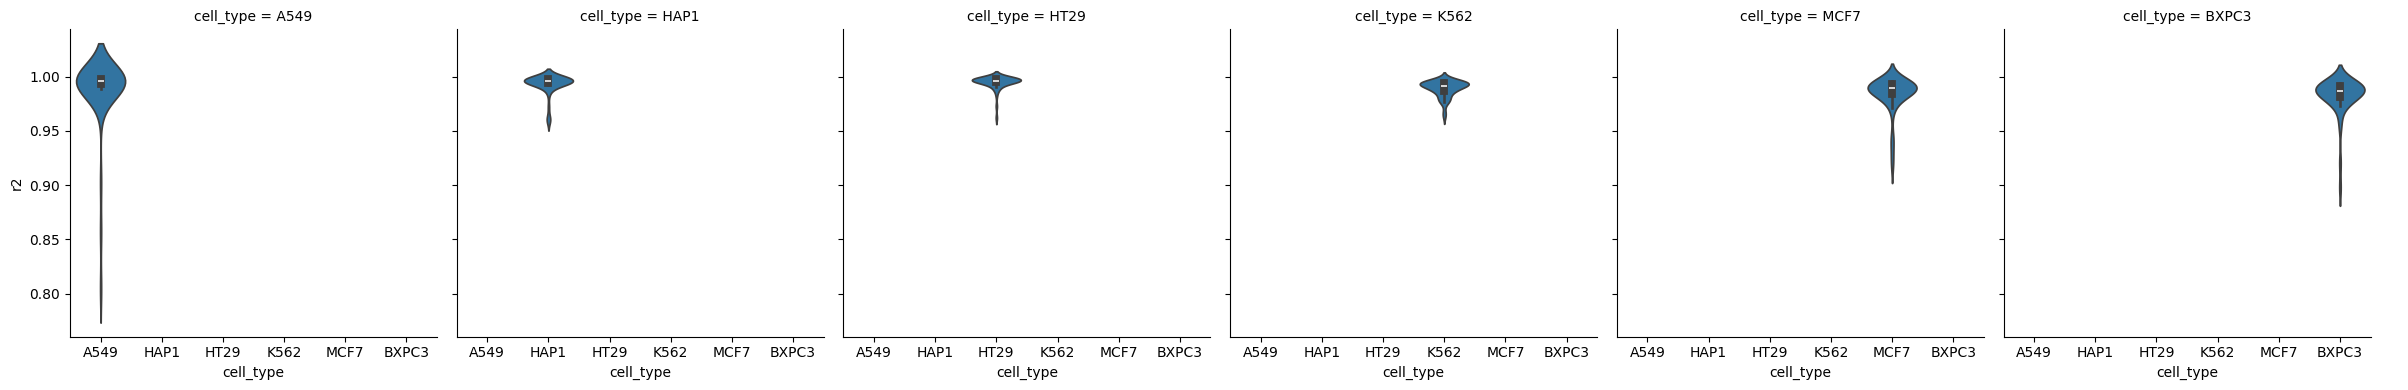

In [35]:
g = sns.FacetGrid(pert_effect_per_cell_type_fg, col='cell_type', height=4, aspect=1)
g.map_dataframe(sns.violinplot, x='cell_type', y='r2')
g.add_legend()
plt.show()

In [36]:
pert_effect_per_cell_type_fg.query('cell_type == "A549"').sort_values(by='r2',ascending=True)

,pathway,cell_type,gene,r2,sinkhorn
51,tgfb,A549,TGFBR1,0.804902,None
43,tgfb,A549,SMAD4,0.856985,None
44,tgfb,A549,TGFBR2,0.902915,None
8,tgfb,A549,KRAS,0.973590,None
22,tgfb,A549,MED15,0.975789,None
47,tgfb,A549,CUL1,0.985584,None
6,tgfb,A549,MAPK1,0.988131,None
18,tgfb,A549,TGIF1,0.990816,None
33,tgfb,A549,JUN,0.992777,None
50,tgfb,A549,RELA,0.992947,None


In [37]:
cell_type_spec_datasets_filtered[0].obs['condition'].value_counts()

condition
A549_HRAS       3515
A549_SMURF1     3465
A549_RUNX1      2953
A549_SMAD2      2711
A549_NT         2564
A549_HDAC5      2209
A549_PAK1       2058
A549_MED15      2032
A549_AKT1       1836
A549_SMAD3      1728
A549_CREBBP     1651
A549_SMURF2     1596
A549_PRKCA      1582
A549_RPS6KB1    1518
A549_MAPK14     1505
A549_SMAD6      1487
A549_MAP3K7     1444
A549_MYC        1417
A549_SMAD9      1404
A549_IRF7       1336
A549_MAPK3      1287
A549_RUNX3      1205
A549_KRAS       1183
A549_SMAD1      1093
A549_RELA        980
A549_TGIF1       965
A549_SMAD7       955
A549_FOS         938
A549_PPP2CA      901
A549_PIK3CA      884
A549_RBX1        879
A549_SP1         879
A549_TGFBR2      823
A549_NFKB1       812
A549_JUN         789
A549_RUNX2       736
A549_SMAD4       677
A549_FOXP2       673
A549_ATF2        658
A549_MAPK1       647
A549_TGFBR3      611
A549_RAF1        587
A549_CHUK        534
A549_RBL1        479
A549_HDAC4       396
A549_EP300       389
A549_SKP1        382
A54